<h1 align='center'>Employee Attrition: Supervised Segmentation</h1>

<h2>Contents</h2>
<ol>
    <li><a href='#results'>Summary of Results</a></li>
    <li><a href='#source'>Data Source and Discussion</a></li>
    <li><a href='#example'>Entropy and Information Gain Worked Example</a></li>
    <li><a href='#data'>Data Pre-Processing</a></li>
    <li><a href='#ig'>Information Gain for All Variables</a></li>
    <li><a href='#future'>Future Work</a></li>
</ol>

<a id='results'></a><h2>Summary of Results</h2>

In our data, we have at our disposable 35 employee attributes for 1470 employees.  Within these attributes, we have a record of whether the employee has left the company, which is marked by "Attrition" with possible values of "Yes" or "No."  We would like to better understand how the remaining 34 employee attributes could be used to inform a discussion on why a given employee left the company.  Naturally, this will also yield some insight into the attributes important for employee retention.  We approach the present work focused on discerning the structure of the given data, and do not establish a predictive model.

Using information gain and entropy (defined below) as our measures of the predictive potential of each individual variable, we have identified ten employee attributes that provide more information than if we segemented our data on Attrition alone.  These are:

<Figure size 720x360 with 0 Axes>

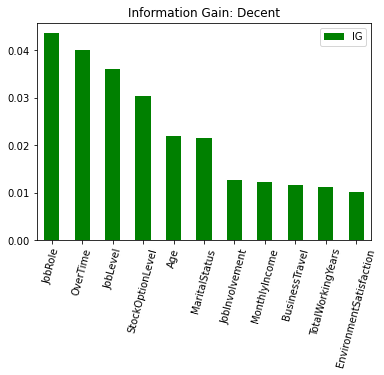

In [36]:
fig_results = plt.figure(figsize=[10, 5])

ig_large = ig_all_df[ig_all_df['IG'] >= .01]

ig_large.sort_values(by=['IG'], ascending = False).plot.bar(color = 'green')

plt.title('Information Gain: Decent')
plt.xticks(rotation=75)

plt.show()

<a id='source'></a><h2>Data Source and Discussion</h2>

This is fictional data, made available by <a href='https://developer.ibm.com/patterns/data-science-life-cycle-in-action-to-solve-employee-attrition-problem/#description' target='_blank'>IBM</a>.  Included are 1470 observations for the following columns:

In [68]:
attrition_full.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

While this data is very clean, we will adjust the structure to fit our present purposes.  The details and motivations are discussed in the <a href='#data'>Data Pre-Processing</a> section below.

<a id='example'></a><h2>Entropy and Information Gain Worked Example</h2>

Given 35 attributes with which to measure an employee, it is a daunting task to hold in one's head the full complexity of their behavior over so many dimensions.  As such, the fundamental task we work through here is finding a way to segment the population of employees into groups with respect to Attrition, our so-called target variable.  We begin this process in this section, determining if one variable, BusinessTravel, provides better information if we include it in establishing our segmented groups than simply segmenting along Attrition alone.

To begin, let's see what our data look like segmented along attrition alone.  We can visualize the groups of "Yes" and "No" employees as follows:

In [37]:
import pandas as pd
import numpy as np

In [38]:
attrition_full = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [39]:
import matplotlib.pyplot as plt

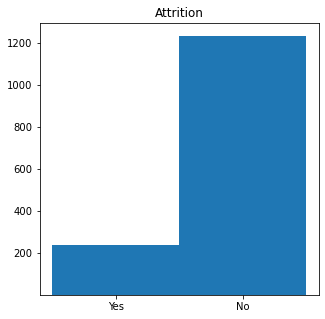

In [40]:
fig0 = plt.figure(figsize=[5, 5])

plt.hist(attrition_full['Attrition'], bins=np.arange(3)-0.5,  bottom=1, align='mid')
plt.title('Attrition')


plt.show()

While this is somewhat useful to understand the proportions of these results, if we want to quantify any future improvements we need to establish a measure of how much order our set of observations possesses.  Entropy is discussed in detail on the <a href='https://en.wikipedia.org/wiki/Entropy_(information_theory)' target='_blank'>wiki</a>, and for our purposes we view it as a measure of disorder on a given set.

We will calculate the entropy, with respect to attrition, of the full data set, where entropy is defined as $$entropy = - \sum p_i log_2(p_i)$$
and $p_i$ is the probability (as a relative frequency) of the property $i$ occuring within the set.  In particular, here, our properties are "Yes" and "No".

In [41]:
p_y = len(attrition_full[attrition_full['Attrition'] == 'Yes'])/len(attrition_full)
p_n = 1- p_y
parent_entropy = -p_y * np.log2(p_y) - p_n * np.log2(p_n)

In [42]:
parent_entropy

0.6372308920655035

Again, this gives us a numerical description of the amount of disorder within our set.  The values may range from zero to one, where zero indicates the data is perfectly ordered (homogeneous, in a sense) and one indicates completely disorded (in the sense that there are equal numbers of all attributes).  

Now we will calculate the entropy using the BusinessTravel column to partition the data, still with respect to Attrition.

In [43]:
#brief check of partition categories
attrition_full['BusinessTravel'].unique()

array(['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'], dtype=object)

To be perfectly clear, we aim to establish six groups now:
<ul>
    <li>Travel Rarely and Yes</li>
    <li>Travel Rarely and No</li>
    <li>Travel Frequently and Yes</li>
    <li>Travel Frequently and No</li>
    <li>Non-Travel and Yes</li>
    <li>Non-Travel and No</li>
</ul>
And, our objective is to measure the amount of disorder.  If we find that there is more order in this segmentation, that indicates that the value of the BusinessTravel attribute has some effect on whether or not an employee left the company.

For clarity, we choose to hardcode the calculation here, but will establish a general function later on.

In [44]:
#first need probablity (as relative frequency) of each subcategory within all data
business_travel_probability = {}
for value in attrition_full['BusinessTravel'].unique():
    business_travel_probability[value] = len(attrition_full[attrition_full['BusinessTravel'] == value])/len(attrition_full)

#then need probability (as rel. freq.) of having a "Yes" value within each subcategory
business_travel_partition = {}
for value in attrition_full['BusinessTravel'].unique():
    business_travel_partition[value] = len(attrition_full[(attrition_full['Attrition'] == 'Yes') & (attrition_full['BusinessTravel'] == value)])/len(attrition_full[attrition_full['BusinessTravel'] == value])
    
#finally calculate entropy based on probabilities of "Yes" and "No" Attrition values within each subcategory
business_travel_entropy = {}
for key, value in business_travel_partition.items():
    business_travel_entropy[key] = -value * np.log2(value) - (1-value) * np.log2(1-value)

This yields the three necessary entropy scores

In [45]:
business_travel_entropy

{'Travel_Rarely': 0.6087595525988123,
 'Travel_Frequently': 0.8098445166230481,
 'Non-Travel': 0.4021791902022728}

Information Gain (IG) is "the amount of information gained about a random variable or signal from observing another random variable", via the <a href='https://en.wikipedia.org/wiki/Information_gain_in_decision_trees' target='_blank'>wiki</a>.

It will yield, for us here, a single number that will establish if partitioning along the BusinessTravel column is advantageous.

More precisely, IG is defined as 
$$IG = entropy(parent) - \sum p(child) × entropy(child)$$

We will refer to this sum as the total child entropy.  Using the calculations above, the total child entropy for BusinessTravel is:

In [46]:
total_child_entropy = (business_travel_probability['Travel_Rarely'] * business_travel_entropy['Travel_Rarely']) + (business_travel_probability['Travel_Frequently'] * business_travel_entropy['Travel_Frequently'] )+ (business_travel_probability['Non-Travel'] * business_travel_entropy['Non-Travel'])

In [47]:
total_child_entropy

0.6255714442146166

Thus, our information gain is:

In [48]:
parent_entropy - total_child_entropy

0.011659447850886906

Indicating a slight decrease in entropy, and we can conclude that the attribute does provide information on the value of our target.

<a id='data'></a><h2>Data Pre-Processing</h2>

In order to find the information gain for all relevant variables, we will need to make some adjustments to our data set, which we will save in a new dataframe.  First, we will establish those variables that may be retained unchanged and identify those columns that are not relevant to the present analysis.  Then, we will adjust the existing categorical variables to have more descriptive names, rather than the numerical categorization with which the data were labelled.  Finally, because the above discussion of entropy relies on the use of categorical variables, we will bin the ratio variables into thirds and apply categorical labels.

note: we perform the above obectives sequentially, while acknowledging that it would be more efficient to do so in one fell swoop.

To begin, we observe that Attrition and EmployeeNumber do not require any adjustment and will be retained in their current form.

In [49]:
attrition_focused = attrition_full[['Attrition','EmployeeNumber']]

Further, we will discard (i.e., not pass into our new dataframe) EmployeeCount as all values are affirmative, Over18 as all values are 'Yes', and StandardHours as all values are 80.

There are 17 variables that are already categorical.  Three of these, JobLevel, StockOptionLevel, and TrainingTimesLastYear, presently are numeralical.  The dataset does not make clear if these are actually interval or ratio variables, but for our current efforts, it will suffice to treat them categorically.  There are seven additional variables that are nicely categorized and require no adjustment.  As such, we will pass these 10 in unaltered.

In [50]:
attrition_focused = attrition_focused.join(attrition_full.loc[:,['JobLevel',
                                                                 'StockOptionLevel',
                                                                 'TrainingTimesLastYear',
                                                                 'BusinessTravel',
                                                                 'Department',
                                                                 'EducationField',
                                                                 'Gender',
                                                                 'JobRole',
                                                                 'MaritalStatus',
                                                                 'OverTime']])

For the remaining seven, we will first add the columns to our new dataframe unchanged.  Then we will change the values according to the label dictionaries (defined by the poster of the data) we establish below.

In [51]:
attrition_focused = attrition_focused.join(attrition_full.loc[:,['Education',
                                                                 'EnvironmentSatisfaction',
                                                                 'JobInvolvement',
                                                                 'JobSatisfaction',
                                                                 'PerformanceRating',
                                                                 'RelationshipSatisfaction',
                                                                 'WorkLifeBalance']])

In [52]:
#Establish our label dictionaries, including an entry for the corresponding column
#Some of these apply the same schema, but I think, relative to the function in the next cell, 
#the reasoning is easier to follow in this format, so I will keep the redundancies.
#Also, the redunant format has the advantage that the schema will be easier to change if future need requires

Education_dict = {
    1: 'Below College',
    2: 'College',
    3: 'Bachelor',
    4: 'Master',
    5: 'Doctor',
    'col': 'Education'
}

EnvironmentSatisfaction_dict = {
    1: 'Low',
    2: 'Medium',
    3: 'High',
    4: 'Very High',
    'col': 'EnvironmentSatisfaction'
}

JobInvolvement_dict = {
    1: 'Low',
    2: 'Medium',
    3: 'High',
    4: 'Very High',
    'col': 'JobInvolvement'
}

JobSatisfaction_dict = {
    1: 'Low',
    2: 'Medium',
    3: 'High',
    4: 'Very High',
    'col': 'JobSatisfaction'
}

PerformanceRating_dict = {
    1: 'Low',
    2: 'Good',
    3: 'Excellent',
    4: 'Outstanding',
    'col': 'PerformanceRating'
}

RelationshipSatisfaction_dict = {
    1: 'Low',
    2: 'Medium',
    3: 'High',
    4: 'Very High',
    'col': 'RelationshipSatisfaction'
}

WorkLifeBalance_dict = {
    1: 'Bad',
    2: 'Good',
    3: 'Better',
    4: 'Best',
    'col': 'WorkLifeBalance'
}

In [53]:
#we define a function to change the values in a given column according to our label dictionaries
def changeLabel(col_dict):
    col = col_dict['col']
    for key,value in col_dict.items():
        if key != 'col':
            attrition_focused.loc[attrition_focused[col] == key, col] = value

In [54]:
#we setup a list of our label dictionaries, over which we iterate and apply the changeLabel function

labels_to_change = [Education_dict,EnvironmentSatisfaction_dict,JobInvolvement_dict,JobSatisfaction_dict,PerformanceRating_dict,RelationshipSatisfaction_dict,WorkLifeBalance_dict]

for x in labels_to_change:
    changeLabel(x)

With this work complete, our dataframe currently has the structure:

In [55]:
attrition_focused

,Attrition,EmployeeNumber,JobLevel,StockOptionLevel,TrainingTimesLastYear,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime,Education,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,PerformanceRating,RelationshipSatisfaction,WorkLifeBalance
0,Yes,1,2,0,0,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Yes,College,Medium,High,Very High,Excellent,Low,Bad
1,No,2,2,1,3,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,No,Below College,High,Medium,Medium,Outstanding,Very High,Better
2,Yes,4,1,0,3,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Yes,College,Very High,Medium,High,Excellent,Medium,Better
3,No,5,1,0,3,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Yes,Master,Very High,High,High,Excellent,High,Better
4,No,7,1,1,3,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,No,Below College,Low,High,Medium,Excellent,Very High,Better
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,No,2061,2,1,3,Travel_Frequently,Research & Development,Medical,Male,Laboratory Technician,Married,No,College,High,Very High,Very High,Excellent,High,Better
1466,No,2062,3,1,5,Travel_Rarely,Research & Development,Medical,Male,Healthcare Representative,Married,No,Below College,Very High,Medium,Low,Excellent,Low,Better
1467,No,2064,2,1,0,Travel_Rarely,Research & Development,Life Sciences,Male,Manufacturing Director,Married,Yes,Bachelor,Medium,Very High,Medium,Outstanding,Medium,Better
1468,No,2065,2,0,3,Travel_Frequently,Sales,Medical,Male,Sales Executive,Married,No,Bachelor,Very High,Medium,Medium,Excellent,Very High,Good


For reference, the histogram of each of these variable is given by:

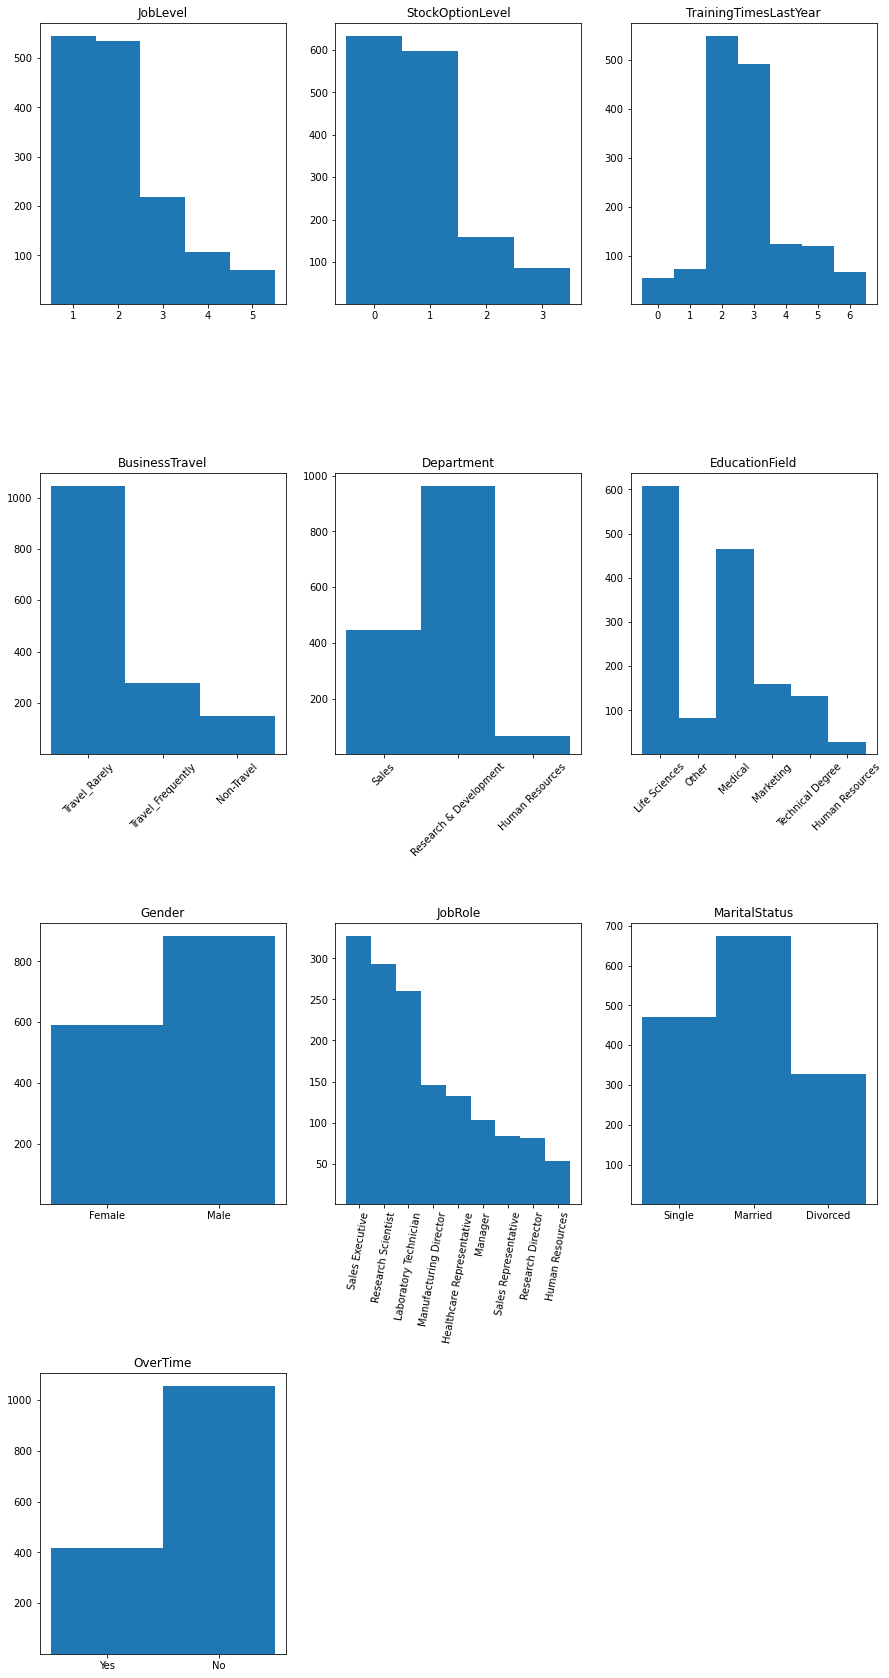

In [56]:
columns_for_hist = ['JobLevel','StockOptionLevel','TrainingTimesLastYear','BusinessTravel','Department','EducationField','Gender','JobRole','MaritalStatus','OverTime']

fig = plt.figure(figsize=[15, 30])

for col in columns_for_hist:
    #setup position on canvas
    i = columns_for_hist.index(col)
    ax = fig.add_subplot(4,3,i+1)
    
    #setup particulars of histogram parameters
    length = len(attrition_focused[col].unique())
    
    if col == 'JobLevel':
        bins_array = [0.5,1.5,2.5,3.5,4.5,5.5]
    else:
        bins_array = np.arange(length + 1)-0.5
    
    #the actual plot
    ax.hist(attrition_focused[col],bins=bins_array,  bottom=1, align='mid')
    ax.set_title(col)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(attrition_focused[col].unique(), minor=False)
    
    #some values are too long to sit adjacently, so we will rotate the labels for those columns
    if col in ['BusinessTravel','Department','EducationField','JobRole']:
        for tick in ax.get_xticklabels():
            if col == 'JobRole':
                tick.set_rotation(80)
            else:
                tick.set_rotation(45)
    

plt.subplots_adjust(hspace = 0.6)
plt.show()


Finally, there are ten ratio variables.  The corresponding distributions are given by:

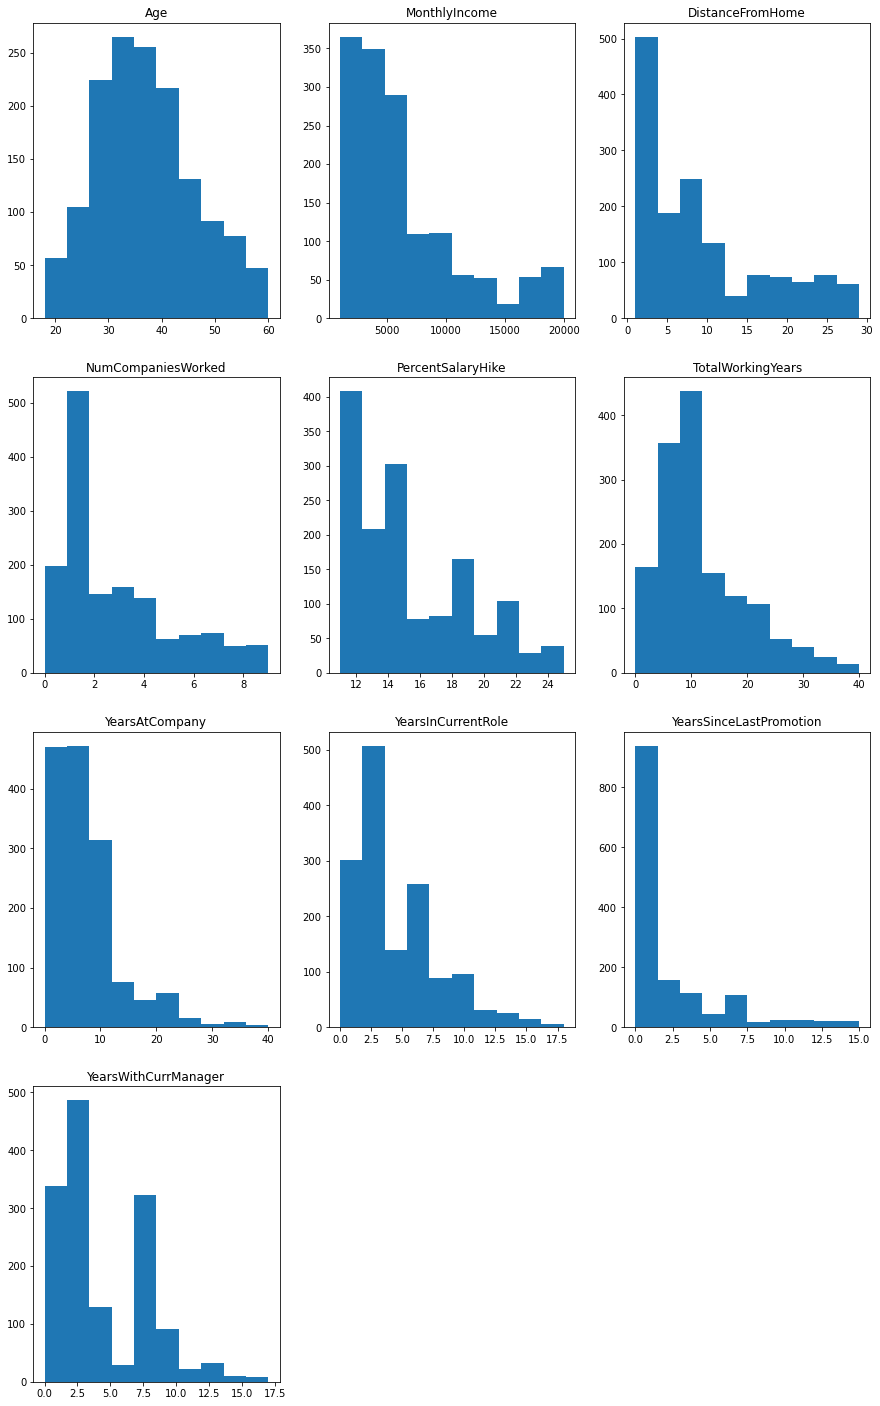

In [57]:
columns_to_bin = ['Age','MonthlyIncome','DistanceFromHome','NumCompaniesWorked','PercentSalaryHike','TotalWorkingYears','YearsAtCompany','YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager']

fig1 = plt.figure(figsize=[15, 25])

for col in columns_to_bin:
    #setup position on canvas
    i = columns_to_bin.index(col)
    ax1 = fig1.add_subplot(4,3,i+1)
    
    #the actual plot
    ax1.hist(attrition_full[col])
    ax1.set_title(col)
    
    
plt.subplots_adjust(hspace = 0.2)
plt.show()

Note: most of these are heavily skewed right.

While these lend themselves to regression techniques, we will bin them into categorical variables for the present work.  In each case, we will divide the observation range into thirds, and apply a schema consisting of "Low", "Medium", and "High".  Some precision will be lost in doing so.

Note: the original data set differentiates between MonthlyIncome, DailyRate, HourlyRate, and MonthlyRate.  We will retain only MonthlyIncome, serving as a proxy for the other three (this is reasonable here, in part, because of the uniformity of StandardHours and because we do not have details on the amount of overtime worked).

We will begin by adding our columns unchanged:

In [58]:
attrition_focused = attrition_focused.join(attrition_full.loc[:,columns_to_bin])
#attrition_focused = attrition_focused.drop(columns_to_bin, axis=1)

Then we will define our general function to relabel the data:

In [59]:
#we define a function to change the values in a given column according to our 3 uniform subintervals
def changeRatioToBin(col):
    #setup our internal subinterval bounds
    ran = attrition_full[col].max() - attrition_full[col].min()
    x1 = attrition_full[col].min() + ran/3
    x2 = attrition_full[col].min() + 2*ran/3
    
    attrition_focused[col] = attrition_focused[col].apply(lambda x: 'Low' if x <= x1 else ('Medium' if x <= x2 else 'High'))

Finally, we will loop through our columns and apply our function.

In [60]:
for x in columns_to_bin:
    changeRatioToBin(x)

For reference, the new distributions are given by:

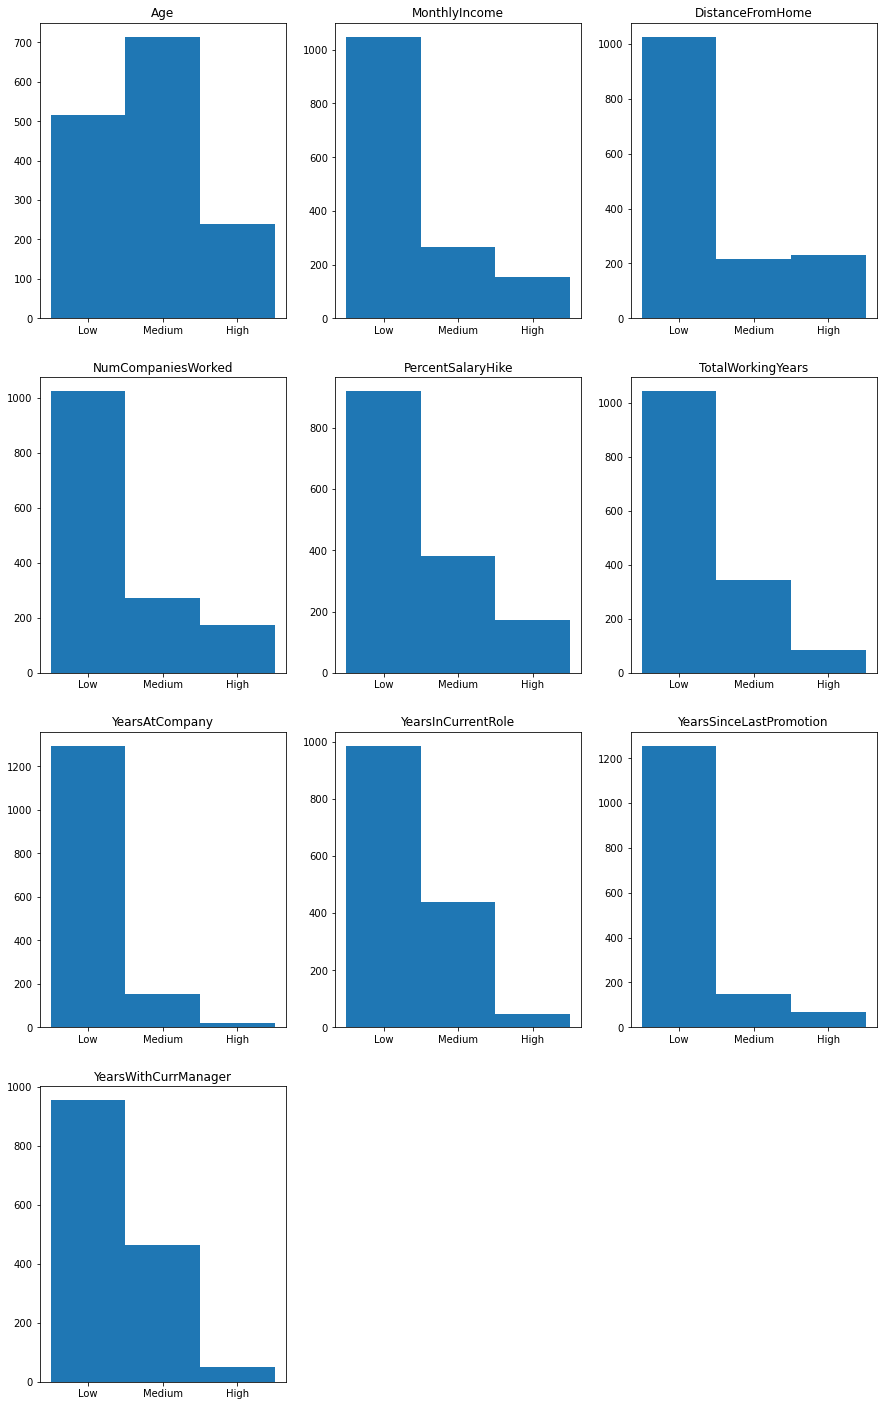

In [61]:
fig2 = plt.figure(figsize=[15, 25])

for col in columns_to_bin:
    #setup position on canvas
    i = columns_to_bin.index(col)
    ax2 = fig2.add_subplot(4,3,i+1)
    
    #the actual plot, with an applied sorting to ensure Low, Medium, High is how the histograms are ordered
    ax2.hist(attrition_focused[col].sort_values(key=lambda x: x.replace('Low', 'a').replace('Medium', 'b').replace('High', 'c')), bins = np.arange(4)-0.5)
    ax2.set_title(col)
    
    
plt.subplots_adjust(hspace = 0.2)
plt.show()

note: while this binning process does lose some of the granularity of the data observations, we have mostly retained the skewed-right attribute of each distribution.

<a id='ig'></a><h2>Information Gain for All Variables</h2>

With our data now in a useable form, we turn our attention to computing the information gain for each variable.  We will follow the reasoning in our worked example, and define some general functions to automate the requisite calculations.

In [62]:
#we have three components that we need and one component for caution, let:
#p_freq = the frequency in which the value occurs within the column of interest
#p_yes = the frequency in which "Yes" occurs in attrition for the selected component of the partition
#........because attrition is binary, we will use p_no = 1 - p_yes
#ent = the entropy for each given partition
#size = number of elements in each component of the partition
#so we will build a dictionary where each entry is of the form, component: [p_freq, p_yes, ent, size]

def totalChildEntropy(col):
    total_child_entropy = 0

    child_dict = {}
    for x in attrition_focused[col].unique():
        child_dict[x] = [len(attrition_focused[attrition_focused[col] == x])/len(attrition_focused)]

        child_dict[x].append(
             len(attrition_focused[(attrition_focused['Attrition'] == 'Yes') & (attrition_focused[col] == x)])/len(attrition_focused[attrition_focused[col] == x])
            )

        child_dict[x].append(
            -child_dict[x][1] * np.log2(child_dict[x][1]) - (1-child_dict[x][1]) * np.log2(1-child_dict[x][1])
            )

        total_child_entropy += child_dict[x][0] * child_dict[x][2]
        
        child_dict[x].append(
             len(attrition_focused[attrition_focused[col] == x])
            )

    return [total_child_entropy, child_dict]


Because we have calculated the sum of all entropy values in the child, we simply need to subtract this value from the parent entropy for each.

In [63]:
ig_all = {}

for col in attrition_focused.columns:
    if (col != 'Attrition') and (col != 'EmployeeNumber'):
        ig_all[col] = parent_entropy - totalChildEntropy(col)[0]

In [64]:
#in order to have sorting capabilities, we will pass into a dataframe
ig_all_df = pd.DataFrame.from_dict(ig_all, orient='index',columns=['IG'])

ig_all_df.sort_values(by=['IG'], ascending = False)

,IG
JobRole,0.043629
OverTime,0.039945
JobLevel,0.036039
StockOptionLevel,0.030274
Age,0.022004
MaritalStatus,0.021591
JobInvolvement,0.012598
MonthlyIncome,0.012214
BusinessTravel,0.011659
TotalWorkingYears,0.011192


<Figure size 720x360 with 0 Axes>

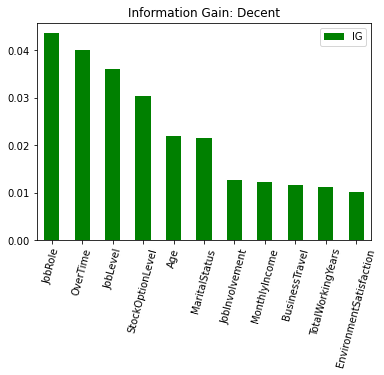

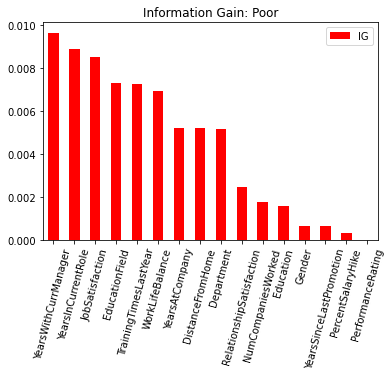

In [65]:
fig3 = plt.figure(figsize=[10, 5])

ig_large = ig_all_df[ig_all_df['IG'] >= .01]
ig_small = ig_all_df[ig_all_df['IG'] < .01]

ig_large.sort_values(by=['IG'], ascending = False).plot.bar(color = 'green')

plt.title('Information Gain: Decent')
plt.xticks(rotation=75)

ig_small.sort_values(by=['IG'], ascending = False).plot.bar(color = 'red')

plt.title('Information Gain: Poor')
plt.xticks(rotation=75)



plt.show()

<a id='future'></a><h2>Future Work</h2>

This work only establishes IG on one level of partitioning.  We will expand these results to build a decision tree with IG rating for the most effective nested partitions.  Note for future reference: this will require adjusting the totalChildEntropy function so that it looks at the relevant parent node (perhaps implementing a stack to track a descending path), rather than the hardcoded version of attrition as I did here.

From there, in order to robustly view the structure of the data we will build a probability estimation tree.
